**# 样式迁移**

In [ ]:
!pip install d2l
!pip install matplotlib==3.0

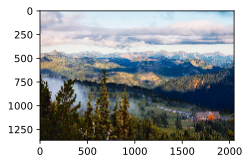

In [ ]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
content_img = d2l.Image.open('/content/drive/MyDrive/Colab Notebooks/Pytorch/06_计算机视觉/rainier.jpeg')
d2l.plt.imshow(content_img);

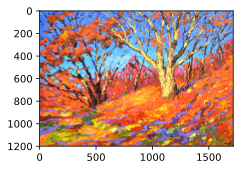

In [ ]:
style_img = d2l.Image.open('/content/drive/MyDrive/Colab Notebooks/Pytorch/06_计算机视觉/autumn-oak.jpeg')
d2l.plt.imshow(style_img);

**预处理和后处理**

*  预处理函数preprocess对输入图像在RGB三个通道分别做标准化，并将结果变换成卷积神经网络接受的输入格式。 
*  后处理函数postprocess则将输出图像中的像素值还原回标准化之前的值。 由于图像打印函数要求每个像素的浮点数值在0到1之间，对小于0和大于1的值分别取0和1。

In [ ]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)  # 表示在第0维增加一个维度

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

**抽取图像特征**

In [ ]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

In [2]:
# 哪些层用来匹配样式，哪些层用来匹配内容
# 越小越接近输入，越大越靠近输出

style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [ ]:
# 使用在ImageNet数据集上预训练的ResNet-18作为源模型。
# 指定pretrained=True以自动下载预训练的模型参数

net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)]) # 选取0-28层

* 给定输入`X`，如果简单地调用前向传播`net(X)`，只能获得最后一层的输出。
* 由于还需要中间层的输出，因此在这里逐层计算，并保留内容层和风格层的输出。

In [ ]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)   # 逐层抽取
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [ ]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

**定义损失函数**

**1. 内容损失**

* 内容损失通过平方误差函数衡量合成图像与内容图像在内容特征上的差异。
* 平方误差函数的输入为`extract_features`函数计算所得到的内容层的输出。

In [ ]:
# 内容损失

def content_loss(Y_hat, Y):
    # 从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

**2. 样式损失**

* 为了表达风格层输出的风格，先通过`extract_features`函数计算风格层的输出。
假设该输出的样本数为1，通道数为$c$，高和宽分别为$h$和$w$，我们可以将此输出转换为矩阵$\mathbf{X}$，其有$c$行和$hw$列。
这个矩阵可以被看作是由$c$个长度为$hw$的向量$\mathbf{x}_1, \ldots, \mathbf{x}_c$组合而成的。其中向量$\mathbf{x}_i$代表了通道$i$上的风格特征。

* 在这些向量的格拉姆矩阵$\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{c \times c}$中，$i$行$j$列的元素$x_{ij}$即向量$\mathbf{x}_i$和$\mathbf{x}_j$的内积。它表达了通道$i$和通道$j$上风格特征的相关性。用这样的格拉姆矩阵来表达风格层输出的风格。
需要注意的是，当$hw$的值较大时，格拉姆矩阵中的元素容易出现较大的值。
此外，格拉姆矩阵的高和宽皆为通道数$c$。
为了让风格损失不受这些值的大小影响，下面定义的`gram`函数将格拉姆矩阵除以了矩阵中元素的个数，即$chw$。


In [ ]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]  # 'h x w' 即为 'n'
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

In [ ]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

**3. 全变分损失**

* 有时候，学到的合成图像里面有大量高频噪点，即有特别亮或者特别暗的颗粒像素。
一种常见的去噪方法是全变分去噪（total variation denoising）：
假设$x_{i, j}$表示坐标$(i, j)$处的像素值，降低全变分损失$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|$$ 能够尽可能使邻近的像素值相似。

In [ ]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

**损失函数**

* **风格转移的损失函数是内容损失、风格损失和总变化损失的加权和**。
通过调节这些权重超参数，可以权衡合成图像在保留内容、迁移风格以及去噪三方面的相对重要性。

In [ ]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

**初始化合成图像**

* 在样式迁移中，合成的图像是训练期间唯一需要更新的变量。因此，可以定义一个简单的模型`SynthesizedImage`，并将合成的图像视为模型参数。模型的前向传播只需返回模型参数即可。

In [ ]:
class SynthesizedImage(nn.Module): 
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

**训练模型**

In [ ]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)  
    # 用X.data覆盖随机初始化的weights就是将原图片本身作为合成好的图片(可以考虑采用内容图片作为初始化)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    # 样式图像在各个风格层的格拉姆矩阵`styles_Y_gram`将在训练前预先计算好
    return gen_img(), styles_Y_gram, trainer

In [ ]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

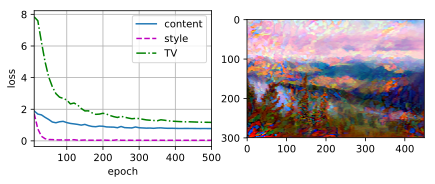

In [ ]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)